In [1]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation

def Q1():
    twenty_all_train = fetch_20newsgroups()
    plt.hist(twenty_all_train.target, bins=20)
    plt.title("Histogram of documents per topic")
    plt.xlabel("Topic")
    plt.ylabel("Number of documents")
    plt.show()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    wnl = nltk.wordnet.WordNetLemmatizer()
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    analyzer = CountVectorizer().build_analyzer()
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

def GetLSA(data, k=50):
    svd = TruncatedSVD(n_components=k, random_state=0)
    data_reduced = svd.fit_transform(data)
    error = np.sum(np.array(data - svd.inverse_transform(data_reduced))**2)
    return data_reduced, error

def GetNMF(data, k=50):
    model = NMF(n_components=k, init='random', random_state=0)
    data_reduced = model.fit_transform(data)
    error = np.sum(np.array(data - data_reduced.dot(model.components_))**2)
    return data_reduced, error

def GetTFData(multiclass=False):
    comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
    rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
    all_categories = comp_categories + rec_categories
    if multiclass:
        all_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
        
    twenty_train = fetch_20newsgroups(subset='train', categories=all_categories, shuffle=True, random_state=None)
    twenty_test = fetch_20newsgroups(subset='test', categories=all_categories, shuffle=True, random_state=None)

    count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')
    tfidf_transformer = TfidfTransformer()

    X_train_counts = count_vect.fit_transform(twenty_train.data)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print("Train tf-idf shape:", X_train_tfidf.shape)

    X_test_counts = count_vect.fit_transform(twenty_test.data)
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
    print("Test tf-idf shape:", X_test_tfidf.shape)
    print()

    if multiclass:
        class_map = {
            'comp.sys.ibm.pc.hardware' : 0, 
            'comp.sys.mac.hardware' : 1,
            'misc.forsale' : 2,
            'soc.religion.christian' : 3
        }
        y_train = []
        y_test = []
        for t in twenty_train.target:
            y_train.append(class_map[t])
        for t in twenty_test.target:
            y_test.append(class_map[t])
    
    y_train = np.array(twenty_train.target > 3)
    y_test = np.array(twenty_test.target > 3)

    return X_train_tfidf, X_test_tfidf, y_train, y_test

def GetData(get_nmf_error=False, multiclass=False):
    X_train, X_test, y_train, y_test = GetTFData()

    X_train_LSA, error_train_LSA = GetLSA(X_train)
    X_test_LSA, error_test_LSA = GetLSA(X_test)
    print("X_train LSA error:", error_train_LSA)
    print("X_test LSA error:", error_test_LSA)

    if get_nmf_error:
        _, error_train_NMF = GetNMF(X_train)
        _, error_test_NMF = GetNMF(X_test)
        print("X_train NMF error:", error_train_NMF)
        print("X_test NMF error:", error_test_NMF)
    return np.array(X_train_LSA), np.array(X_test_LSA), np.array(y_train), np.array(y_test)

def TrainTestModel(model, X_train, y_train, X_test, y_test, name, show_log_loss=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    accuracy = float(cm[0][0] + cm[1][1])/(np.sum(cm))
    precision = float(cm[0][0]/(cm[0][0] + cm[0][1]))
    recall = float(cm[0][0]/(cm[0][0] + cm[1][0]))
    F1 = 2/((1/precision) + (1/recall))

    print("Results for {} -".format(name))
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", F1)
    if show_log_loss:
        print("Log Loss:", log_loss(y_test, y_pred))
    print()

    plot_roc_curve(model, X_test, y_test)
    plt.title(name + " ROC Curve")
    plt.show()

def CrossValSVM(X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5)
    max_acc = 0.0
    max_k = -3
    for k in range(-3, 4):
        svm = LinearSVC(C=10**k, max_iter=5000)
        acc = 0.0
        for train_index, test_index in kf.split(X_train):
            svm.fit(X_train[train_index], y_train[train_index])
            acc += svm.score(X_train[test_index], y_train[test_index])
        acc /= 5
        if acc > max_acc:
            max_acc = acc
            max_k = k

    print("Max cross val accuracy:", max_acc)
    print("Max K:", max_k)
    print()
    svm = LinearSVC(C=10**max_k, max_iter=5000)
    TrainTestModel(svm, X_train, y_train, X_test, y_test, "Best SVM")

def CrossValLogisticRegression(X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5)
    penalties = ['l2', 'l1']
    for penalty in penalties:
        max_acc = 0.0
        max_k = -3
        for k in range(-3, 4):
            model = LogisticRegression(penalty=penalty, C=10**k, solver='liblinear')
            acc = 0.0
            for train_index, test_index in kf.split(X_train):
                model.fit(X_train[train_index], y_train[train_index])
                acc += model.score(X_train[test_index], y_train[test_index])
            acc /= 5
            if acc > max_acc:
                max_acc = acc
                max_k = k
        
        print("Max cross val accuracy for {} regulaizer:".format(penalty), max_acc)
        print("Max k:", max_k)
        print("Coefficients:", model.coef_)
        print()
        model = LogisticRegression(penalty=penalty, C=10**max_k, solver='liblinear')
        TrainTestModel(model, X_train, y_train, X_test, y_test, penalty + " Regularized Logistic Regression", show_log_loss=True)

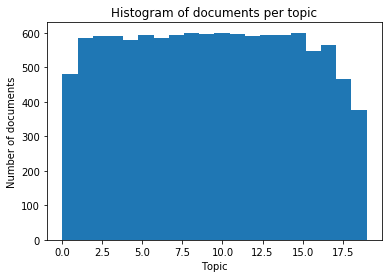

In [2]:
Q1()

In [ ]:
X_train, X_test, y_train, y_test = GetData(get_nmf_error=True)
hard_svm = LinearSVC(C=1000.0, max_iter=5000)
TrainTestModel(hard_svm, X_train, y_train, X_test, y_test, "Hard SVM")

In [ ]:
soft_svm = LinearSVC(C=0.0001)
TrainTestModel(soft_svm, X_train, y_train, X_test, y_test, "Soft SVM")

In [ ]:
CrossValSVM(X_train, y_train, X_test, y_test)

In [ ]:
no_reg_model = LogisticRegression(penalty='none')
TrainTestModel(no_reg_model, X_train, y_train, X_test, y_test, "No Regularization Logistic Regression")

In [ ]:
CrossValLogisticRegression(X_train, y_train, X_test, y_test)

In [ ]:
NB = GaussianNB()
TrainTestModel(NB, X_train, y_train, X_test, y_test, "GaussianNB")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
],
memory=memory
)

N_FEATURES_OPTIONS = [50]

param_grid = [
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LinearSVC()],
        'clf__C': [1]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__penalty' : ['l2'],
        'clf__C' : [100]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__penalty' : ['l1'],
        'clf__C' : [10]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [GaussianNB()],
    },
]

In [ ]:
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
all_categories = comp_categories + rec_categories

twenty_train = fetch_20newsgroups(subset='train', categories=all_categories, shuffle=True, random_state=None)
twenty_test = fetch_20newsgroups(subset='test', categories=all_categories, shuffle=True, random_state=None)

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')

grid.fit(twenty_train.data, np.array(twenty_train.target > 3))
rmtree(cachedir)

In [ ]:
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers'), categories=all_categories, shuffle=True, random_state=None)
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers'), categories=all_categories, shuffle=True, random_state=None)

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')

grid.fit(twenty_train.data, np.array(twenty_train.target > 3))
rmtree(cachedir)

In [ ]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

In [ ]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = GetData(multiclass=True)
ovr_svm = SVC(kernel='linear', decision_function_shape='ovr', max_iter=5000)
TrainTestModel(ovr_svm, X_train, y_train, X_test, y_test, "One-Vs-Rest SVM")

In [ ]:
ovo_svm = SVC(kernel='linear', decision_function_shape='ovo', max_iter=5000)
TrainTestModel(ovo_svm, X_train, y_train, X_test, y_test, "One-Vs-One SVM")

In [ ]:
NB = GaussianNB()
TrainTestModel(NB, X_train, y_train, X_test, y_test, "Multiclass GaussianNB")